# Load Data

In [ ]:
# install PySpark
! pip install pyspark >& /dev/null
! pip install dtreeviz >& /dev/null
# mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive/')

# create Spark Session and Spark Context
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Final-IST718').getOrCreate()

import pandas as pd

data_url = "https://drive.google.com/uc?export=download&id=1a5Xv7z6WmREPqhzflOr33v4ZeRGyl60T"

# source_cancer_data should be thought of as read only
# cancer_data and cancer_df may be altered downstream
source_cancer_data = pd.read_csv(data_url)

cancer_data = source_cancer_data
cancer_df = spark.createDataFrame(source_cancer_data)
cancer_df.show(5)

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|Unnamed: 32|
+--------+---------+----

#Data Exploration

In [ ]:
# summary the data
cancer_df.describe().show()

+-------+--------------------+---------+------------------+-----------------+------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+-----------+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|    perimeter_mean|         area_mean|     smoothness_mean|    compactness_mean|     concavity_mean|concave points_mean|       symmetry_mean|fractal_dimension_mean|          radius_se|        texture_se|      perimeter_se|           area_se|       smoothness_se|     

In [ ]:
# display number of rows with missing value

from pyspark.sql.functions import col, sum as spark_sum

null_counts = cancer_df.select(*(spark_sum(col(c).isNull().cast("int")).alias(c) for c in cancer_df.columns))

null_counts.show()

# no missing value

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|Unnamed: 32|
+---+---------+-----------+-------

In [ ]:
# drop columns
cancer_df = cancer_df.drop("id", "Unnamed: 32")

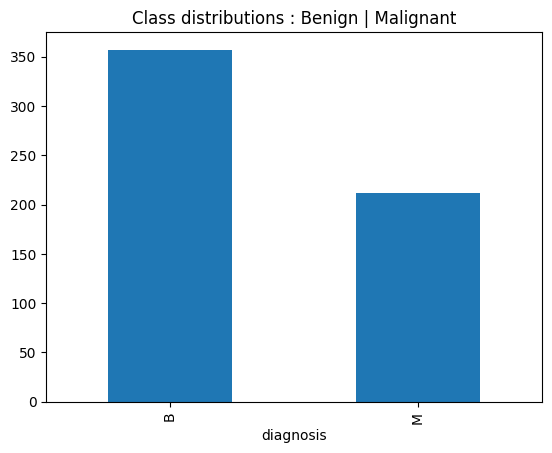

In [ ]:
import matplotlib.pyplot as plt

cancer_pd_df = cancer_df.select('diagnosis').toPandas()

plot = cancer_pd_df['diagnosis'].value_counts().plot(kind='bar', title="Class distributions : Benign | Malignant")
plt.show()


In [ ]:
cancer_data.drop(columns = ["id", "Unnamed: 32"], inplace=True)

feature_list = list(cancer_data.columns[1:11])

df_M=cancer_data[cancer_data['diagnosis'] == "M"]
df_B=cancer_data[cancer_data['diagnosis'] == "B"]

print("Feature list:", feature_list)
print("Number of features:", len(feature_list))

cancer_data["diagnosis"] = cancer_data["diagnosis"].replace(["B" , "M"] , [0,1]).infer_objects()

Feature list: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
Number of features: 10


In [ ]:
cancer_data.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


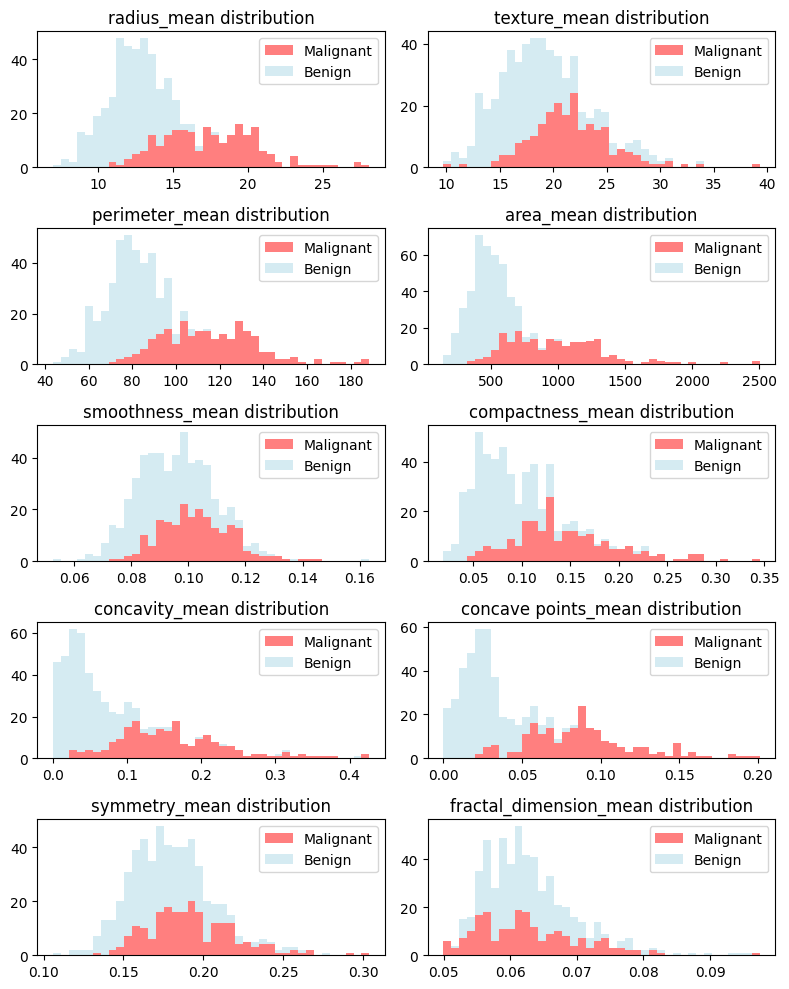

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    feature = feature_list[idx]
    ax.hist([df_M[feature], df_B[feature]],
            bins=40,  # Adjust the number of bins
            alpha=0.5, stacked=True, label=['Malignant', 'Benign'], color=['r', 'lightblue'])

    ax.legend(loc='upper right')
    ax.set_title(feature + " distribution")

plt.tight_layout()
plt.show()


In [ ]:
len(cancer_data.iloc[0, ])
cancer_data_mean = cancer_data.iloc[:, :11]
cancer_data_se = cancer_data.iloc[:, [0] + list(range(11, 21))]
cancer_data_worst = cancer_data.iloc[:, [0] + list(range(21, 31))]

<Axes: >

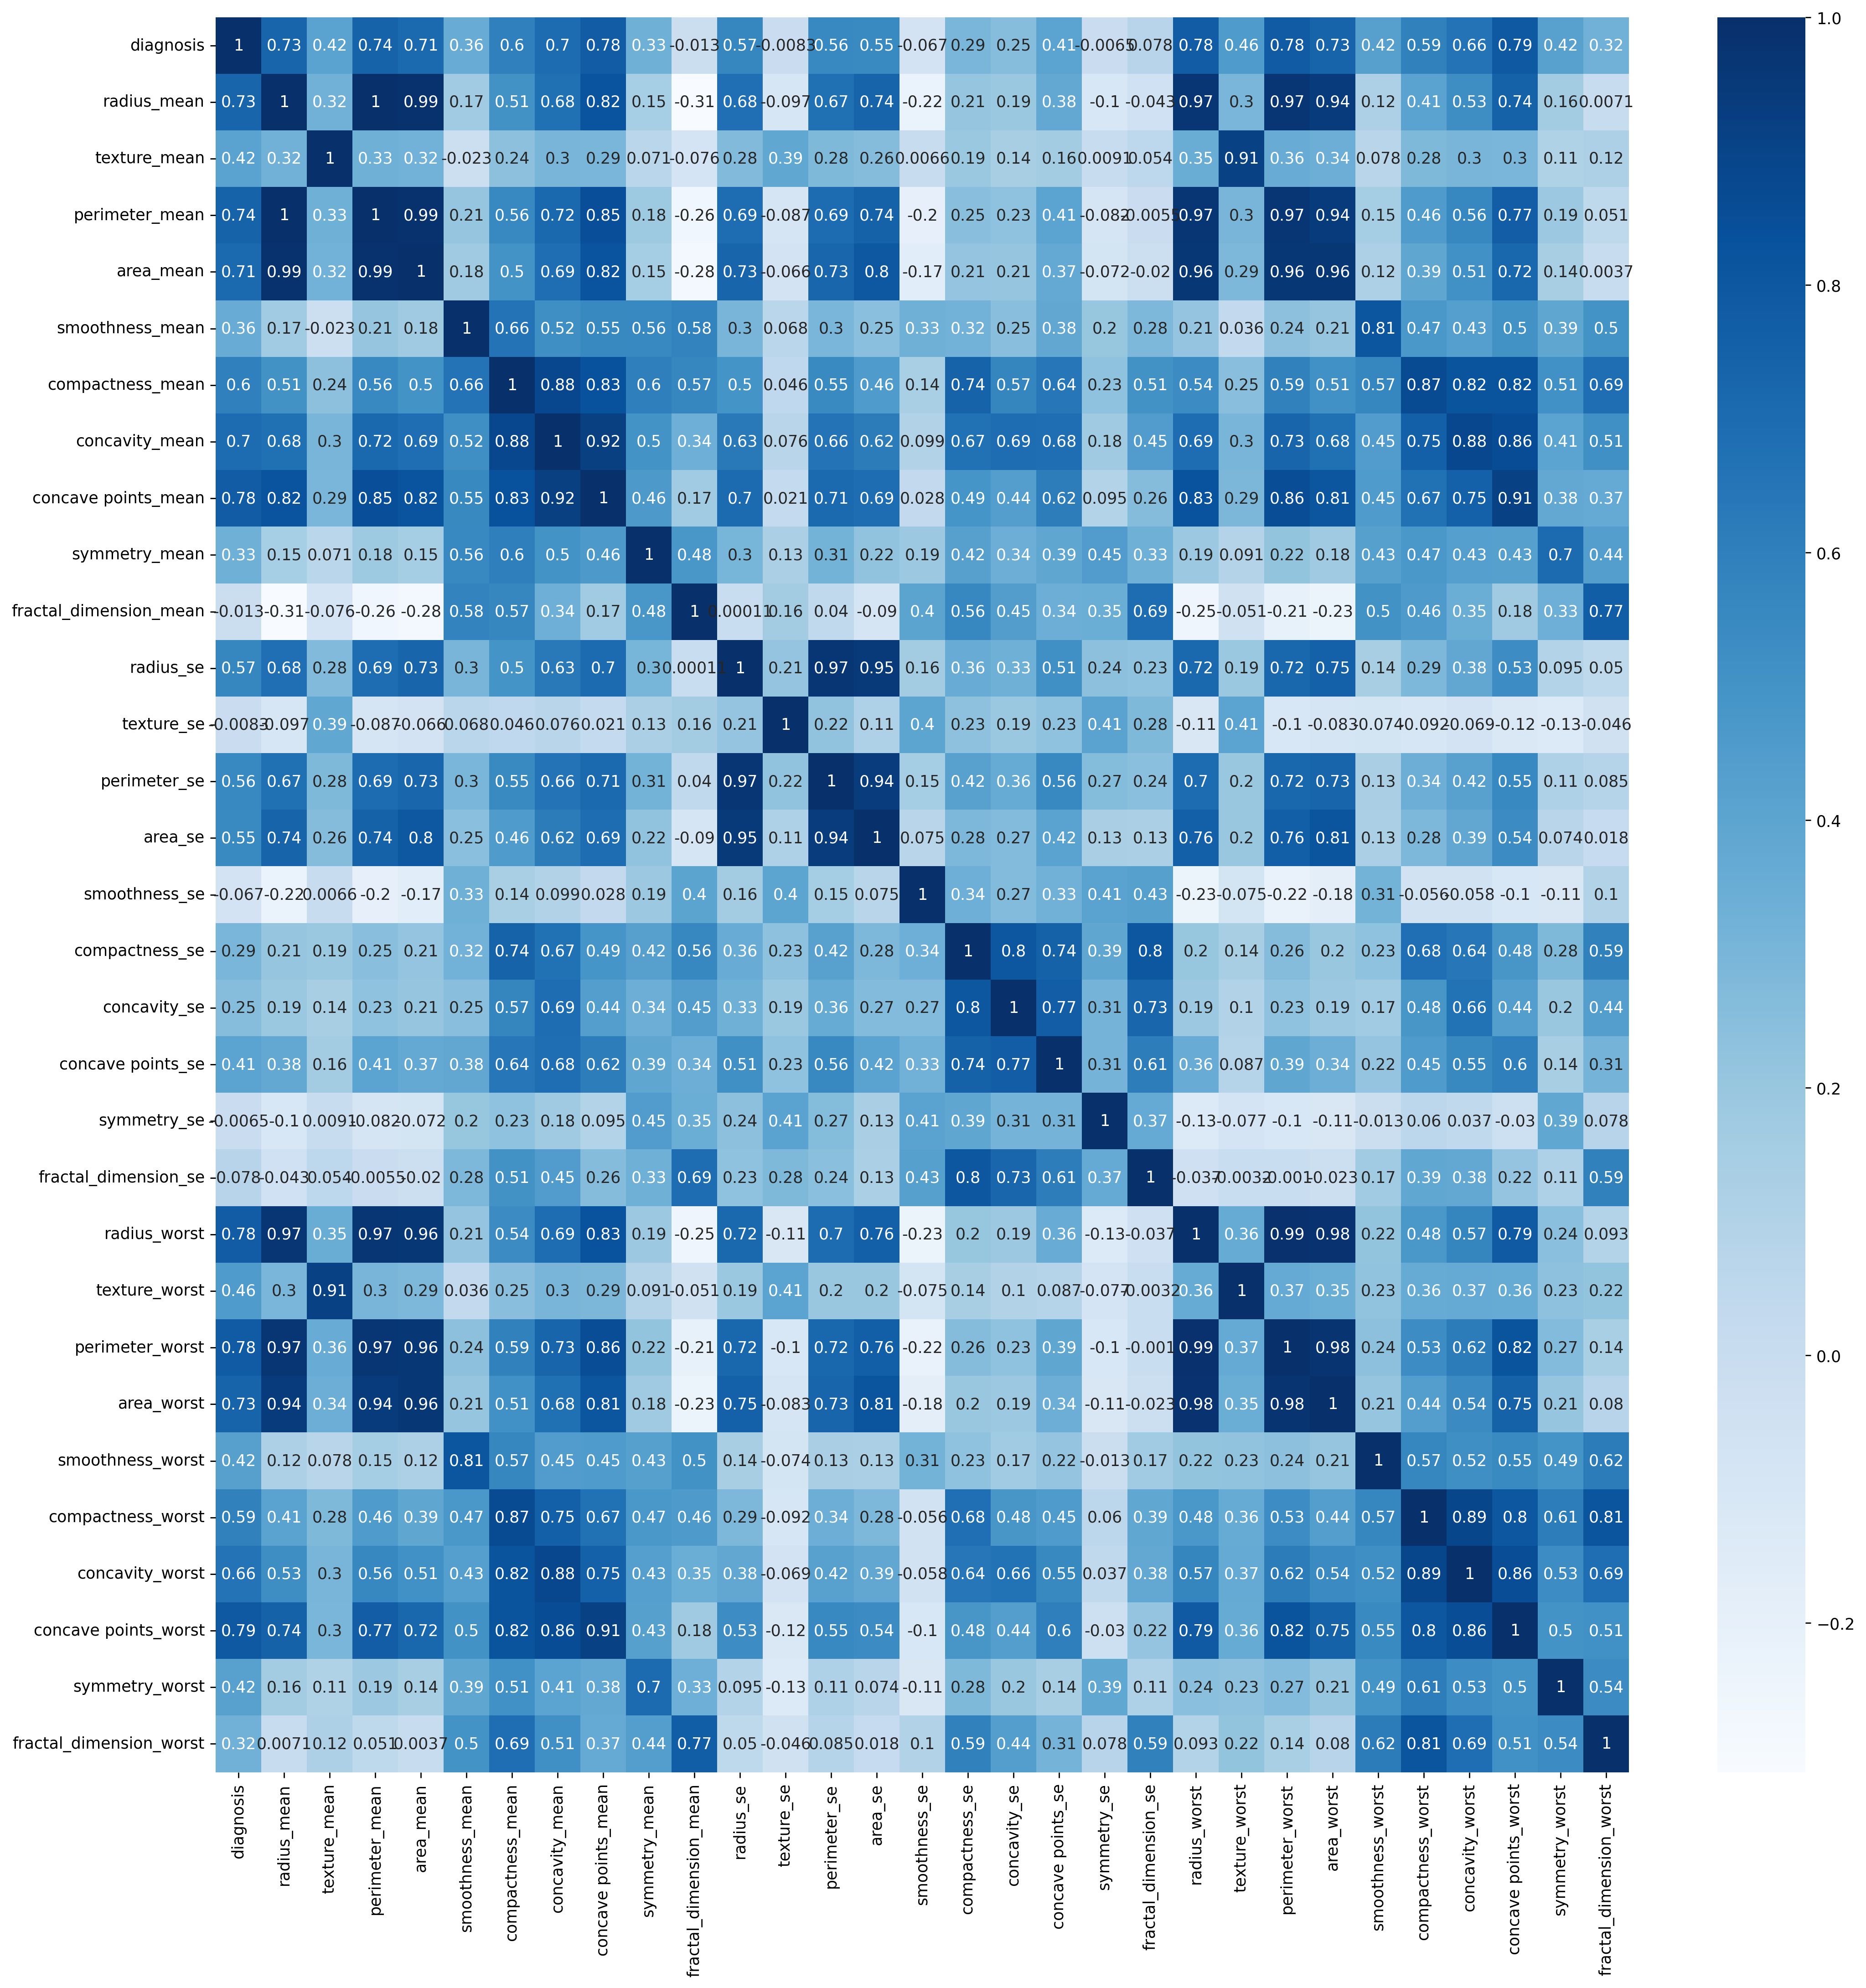

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(20,20), dpi=250)
sns.heatmap(cancer_data.corr(), cmap="Blues", annot=True)


The below columns have very low correlation to diagnosis:
fractal_dimension_mean,
texture_se,
smoothness_se,
symmetry_se,
fractal_dimension_se.

When doing feature engineering, maybe we can try to remove these columns.

<Axes: >

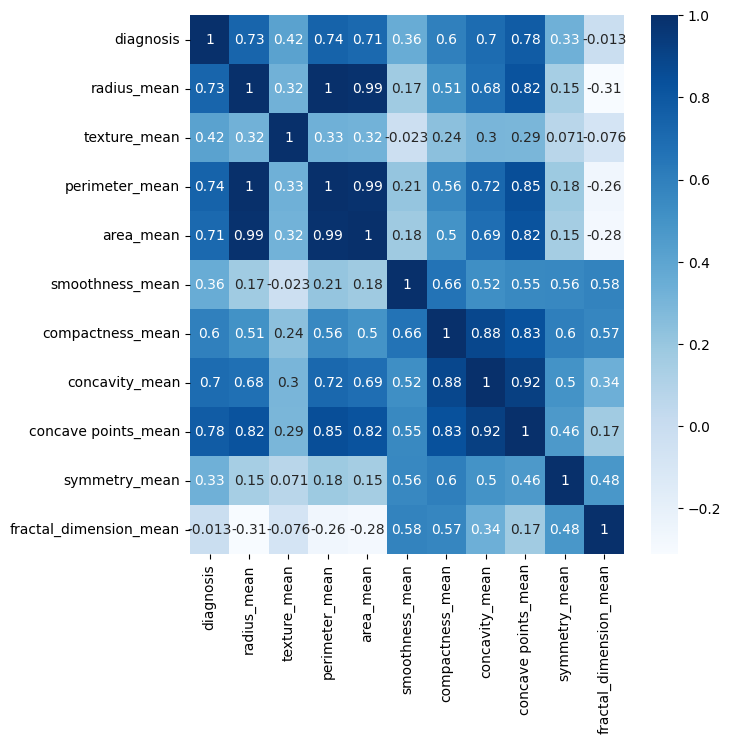

In [ ]:
fig = plt.figure(figsize=(7,7), dpi=100)
sns.heatmap(cancer_data_mean.corr(), cmap="Blues", annot=True)

<Axes: >

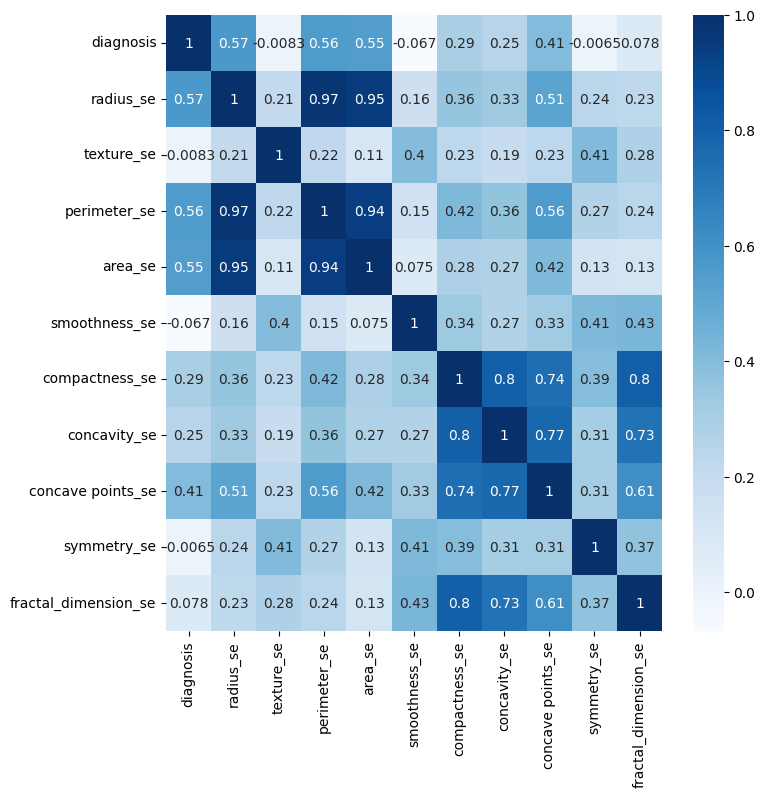

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(cancer_data_se.corr(), cmap="Blues", annot=True)

<Axes: >

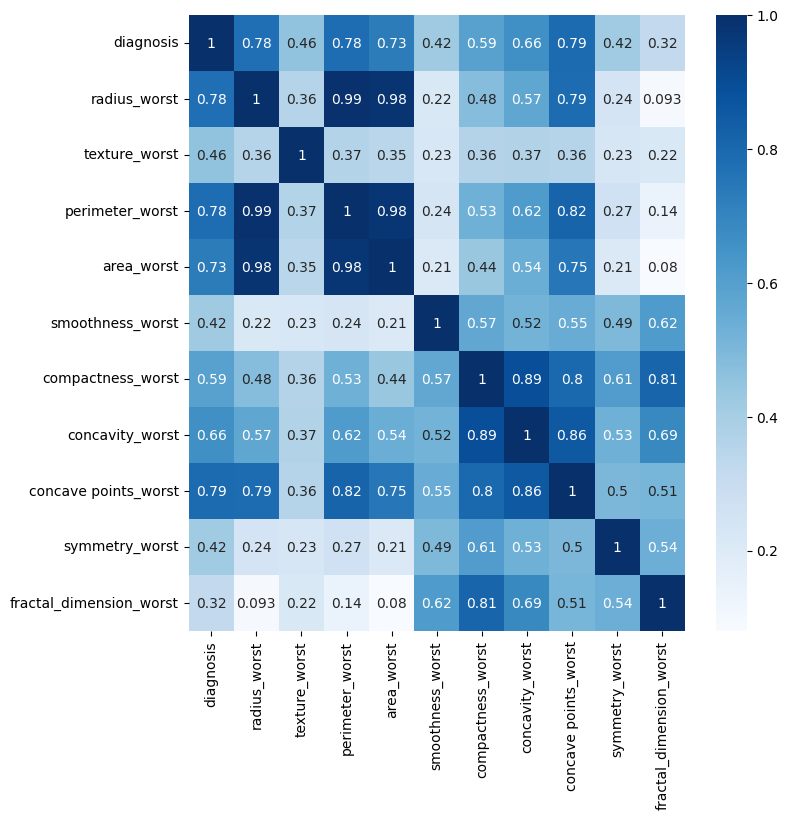

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(cancer_data_worst.corr(), cmap="Blues", annot=True)

# Original Experiment

In [ ]:
cancer_df = spark.createDataFrame(source_cancer_data)

cancer_df = cancer_df[cancer_df.columns[:-1]]

cancer_df.printSchema()

root
 |-- diagnosis: long (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)
 |

In [ ]:
#splitting the dataset
training_df, testing_df = cancer_df.randomSplit([0.7, 0.3], seed = 1502)

In [ ]:
#creating the model pipeline, training based upon the columns used in the original experiment

from pyspark.ml import Pipeline, feature, evaluation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from timeit import default_timer as timer

si = StringIndexer(inputCol = 'diagnosis',
                   outputCol = 'diagnosis_index')
va = VectorAssembler(inputCols = ['texture_mean', 'area_worst', 'smoothness_worst'],
                     outputCol = 'features')
dtc = DecisionTreeClassifier(featuresCol = 'features',
                             labelCol = 'diagnosis_index')

start = timer()
dt_model_original_pipe = Pipeline(stages = [si,va,dtc])
dt_model_original = dt_model_original_pipe.fit(training_df)
end = timer()

print(end-start)


In [ ]:
print(dt_model_original.stages[-1].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6743ac14b8f2, depth=5, numNodes=25, numClasses=2, numFeatures=3
  If (feature 1 <= 868.2)
   If (feature 1 <= 713.35)
    If (feature 2 <= 0.17880000000000001)
     Predict: 0.0
    Else (feature 2 > 0.17880000000000001)
     If (feature 0 <= 14.245000000000001)
      Predict: 0.0
     Else (feature 0 > 14.245000000000001)
      Predict: 1.0
   Else (feature 1 > 713.35)
    If (feature 2 <= 0.13945000000000002)
     If (feature 0 <= 21.395)
      Predict: 0.0
     Else (feature 0 > 21.395)
      If (feature 2 <= 0.12225)
       Predict: 0.0
      Else (feature 2 > 0.12225)
       Predict: 1.0
    Else (feature 2 > 0.13945000000000002)
     Predict: 1.0
  Else (feature 1 > 868.2)
   If (feature 0 <= 15.76)
    If (feature 1 <= 1027.5)
     If (feature 2 <= 0.13640000000000002)
      Predict: 0.0
     Else (feature 2 > 0.13640000000000002)
      Predict: 1.0
    Else (feature 1 > 1027.5)
     Predict: 1.0
   Else (feature 0 > 15

In [ ]:
prediction_columns = ['features', 'diagnosis_index', 'prediction', 'rawPrediction', 'probability']

testing = dt_model_original.transform(testing_df)
testing.select(prediction_columns).show(5, truncate=False)

+--------------------+---------------+----------+-------------+----------------------------------------+
|features            |diagnosis_index|prediction|rawPrediction|probability                             |
+--------------------+---------------+----------+-------------+----------------------------------------+
|[13.43,185.2,0.1584]|0.0            |0.0       |[184.0,4.0]  |[0.9787234042553191,0.02127659574468085]|
|[15.91,335.9,0.1504]|0.0            |0.0       |[184.0,4.0]  |[0.9787234042553191,0.02127659574468085]|
|[11.97,342.9,0.1234]|0.0            |0.0       |[184.0,4.0]  |[0.9787234042553191,0.02127659574468085]|
|[15.46,395.4,0.1341]|0.0            |0.0       |[184.0,4.0]  |[0.9787234042553191,0.02127659574468085]|
|[19.86,402.8,0.1515]|0.0            |0.0       |[184.0,4.0]  |[0.9787234042553191,0.02127659574468085]|
+--------------------+---------------+----------+-------------+----------------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
BCevaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'diagnosis_index')
MCevaluator = MulticlassClassificationEvaluator(labelCol="diagnosis_index", predictionCol="prediction", metricName="accuracy")

roc_auc = BCevaluator.evaluate(testing)
accuracy = MCevaluator.evaluate(testing)

print(f'Area Under ROC Curve: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Area Under ROC Curve for DE TREE: 0.95


In [ ]:
# extract from the pipeline the tree model classifier and create wrapper for visualization
tree_model_classifier = dt_model_original.stages[-1]

features = ['texture_mean', 'area_worst', 'smoothness_worst']
target = 'diagnosis_index'


dataset = Pipeline(stages=[si,va,dtc]) \
    .fit(training_df) \
    .transform(training_df) \
    .toPandas()[features + [target]]

In [ ]:
import dtreeviz

viz_model = dtreeviz.model(tree_model_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["Benign", "Malignant"])

In [ ]:
viz_model.view(fontname="monospace")

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 7, 9, 11]) \
    .addGrid(dtc.minInstancesPerNode, [1, 3, 5, 7, 9]) \
    .addGrid(dtc.maxBins, [2, 4, 6, 8, 10, 32]) \
    .build()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


crossval = CrossValidator(estimator = dt_model_original_pipe,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(
                              labelCol='diagnosis_index',
                              predictionCol='prediction',
                              metricName='accuracy'),
                          numFolds=5)

start = timer()
cvModel = crossval.fit(training_df)
end = timer()
print(end-start)

best_model = cvModel.bestModel

predictions = best_model.transform(testing_df)

roc_auc = BCevaluator.evaluate(predictions)
accuracy = MCevaluator.evaluate(predictions)

print(f'Area Under ROC Curve: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')


686.7374400150002
Test Accuracy: 0.9640


In [ ]:
cvModel.bestModel

PipelineModel_5c633e1cd0ec

In [ ]:
bestPipeline = cvModel.bestModel
bestDTCModel = bestPipeline.stages[2]
bestParams = bestLRModel.extractParamMap()

In [ ]:
print(bestLRModel)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0028525fda87, depth=5, numNodes=25, numClasses=2, numFeatures=3


In [ ]:
print(bestParams)

{Param(parent='DecisionTreeClassifier_0028525fda87', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeClassifier_0028525fda87', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeClassifier_0028525fda87', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeClassifier_0028525fda87', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',

In [ ]:
print(bestPipeline.stages[-1].toDebugString)

In [ ]:
best_tree_model_classifier = bestPipeline.stages[-1]

features = ['texture_mean', 'area_worst', 'smoothness_worst']
target = 'diagnosis_index'

dataset = Pipeline(stages=[si,va,dtc]) \
    .fit(training_df_viz) \
    .transform(training_df_viz) \
    .toPandas()[features + [target]]

In [ ]:
viz_model_best = dtreeviz.model(best_tree_model_classifier,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["Benign", "Malignant"])

In [ ]:
viz_model_best.view(fontname="monospace")

# Neural Network

In [ ]:
cancer_df = spark.createDataFrame(source_cancer_data)
cancer_df.show(5)
seed = 42

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [ ]:
# Split training and testing datasets
train_df, test_df = cancer_df.randomSplit([0.7, 0.3], seed=seed)
print("train", train_df.toPandas().value_counts('diagnosis'))
print("test", test_df.toPandas().value_counts('diagnosis'))

train diagnosis
0    291
1    183
Name: count, dtype: int64
test diagnosis
0    66
1    29
Name: count, dtype: int64


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics

category_to_number_model = StringIndexer(inputCol = 'diagnosis', outputCol = 'label')

def calculate_parameters(architecture):
  '''
  Calculate the number of parameters of certain model.

  Args:
    architecture: the sturcture of the neural network (# of neurons in each layer)
  '''

  params = 0
  print(architecture)
  for i in range(len(architecture) - 1):
      params += (architecture[i] * architecture[i + 1]) + architecture[i + 1]
  print(f"Number of parameters: {params}")


def evaluate(predictions):
  '''
  Evaluate the model and print the information, including confusion matrix, accuracy, precision, recall, and f1-score

  Args:
    predictions: the prediction result of the model
  '''

  # Convert predictions and labels to RDD
  prediction_and_label = predictions.select("prediction", "label").rdd.map(tuple)

  metrics = MulticlassMetrics(prediction_and_label)

  confusion_matrix = metrics.confusionMatrix().toArray()

  confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=["Predict Benign", "Predict Malignance"], index=["Actual Benign", "Actual Malignance"])

  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("="*50)

  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

  accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
  print(f"Accuracy: {accuracy}")

  precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
  print(f"Precision: {precision}")

  recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
  print(f"Recall: {recall}")

  f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
  print(f"F1-score: {f1_score}")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from timeit import default_timer as timer

# Select all "mean" features

# Create feature vector
feature_cols = [col for col in cancer_df.columns if col[-4:] == 'mean']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[10, 32, 16, 2]
Number of parameters: 914
37.392357491999974


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                59.0                 7.0
Actual Malignance             2.0                27.0
Accuracy: 0.9052631578947369
Precision: 0.9143734456681722
Recall: 0.9052631578947369
F1-score: 0.9071576579243383


In [ ]:
# Select all "standard error" features

# Create feature vector
feature_cols = [col for col in cancer_df.columns if col[-2:] == 'se']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[10, 32, 16, 2]
Number of parameters: 914
8.266338998999345


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                61.0                 5.0
Actual Malignance             7.0                22.0
Accuracy: 0.8736842105263158
Precision: 0.8719527577112717
Recall: 0.8736842105263158
F1-score: 0.8723712265738974


In [ ]:
# Select all "worst" features

# Create feature vector
feature_cols = [col for col in cancer_df.columns if col[-5:] == 'worst']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[10, 32, 16, 2]
Number of parameters: 914
7.932027095000194


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                60.0                 6.0
Actual Malignance             4.0                25.0
Accuracy: 0.8947368421052632
Precision: 0.8974957555178268
Recall: 0.894736842105263
F1-score: 0.8956815114709852


In [ ]:
# Select all features, including mean, se, and worst

# Create feature vector
feature_cols = [col for col in cancer_df.columns if col not in ['id', 'diagnosis', 'Unnamed: 32']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[30, 32, 16, 2]
Number of parameters: 1554
10.643863281999984


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                65.0                 1.0
Actual Malignance             6.0                23.0
Accuracy: 0.9263157894736842
Precision: 0.9285705460835187
Recall: 0.9263157894736842
F1-score: 0.9241847215477061


In [ ]:
# Create feature vector
feature_cols = [col for col in cancer_df.columns if col not in ['id', 'diagnosis', 'Unnamed: 32']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 64, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[30, 64, 32, 16, 2]
Number of parameters: 4626
12.343278674999965


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                66.0                 0.0
Actual Malignance             5.0                24.0
Accuracy: 0.9473684210526315
Precision: 0.9510748702742773
Recall: 0.9473684210526316
F1-score: 0.945846229676933


### Feature Engineering for Neural Network

Since we have found some features have very low correlation to diagnosis in the data exploration part:
fractal_dimension_mean,
texture_se,
smoothness_se,
symmetry_se,
fractal_dimension_se.

When doing feature engineering, we try to remove these columns and see the results.

In [ ]:
# Create feature vector
feature_cols = [col for col in cancer_df.columns if col not in ['id', 'diagnosis', 'Unnamed: 32', 'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the layers of the neural network
input_dim = len(feature_cols)
layers = [input_dim, 64, 32, 16, 2]

# Create the model
mlp = MultilayerPerceptronClassifier(layers=layers, seed=seed, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[category_to_number_model, assembler, mlp])

# Train the Model
calculate_parameters(layers)
start = timer()
model = pipeline.fit(train_df)
end = timer()

print(end-start)

# Evaluate predictions
predictions = model.transform(test_df)
evaluate(predictions)

[25, 64, 32, 16, 2]
Number of parameters: 4306
18.62578909800004


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
                   Predict Benign  Predict Malignance
Actual Benign                66.0                 0.0
Actual Malignance             7.0                22.0
Accuracy: 0.9263157894736842
Precision: 0.933381398702235
Recall: 0.9263157894736842
F1-score: 0.9231143877467685


# Additional Models

In [ ]:
cancer_data = source_cancer_data
cancer_df = spark.createDataFrame(cancer_data)
cancer_df.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [ ]:
#splitting the dataset
training_df, validation_df = cancer_df.randomSplit([0.7, 0.3], seed = 1502)
[training_df.count(), validation_df.count()]

[408, 161]

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

si = StringIndexer(inputCol = 'diagnosis', outputCol = 'diagnosis_index')

va = VectorAssembler()\
  .setInputCols(training_df.columns[1:])\
  .setOutputCol('features')

lr = LogisticRegression(regParam = 0.1,\
                        featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
lr_pipeline = Pipeline(stages = [si, va, lr]).fit(training_df)
end = timer()

print(end-start)

rf = RandomForestClassifier(featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
rf_pipeline = Pipeline(stages=[si, va, rf]).fit(training_df)
end = timer()

print(end-start)

gbt = GBTClassifier(featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
gbt_pipeline = Pipeline(stages=[si, va, gbt]).fit(training_df)
end = timer()

print(end-start)


16.932792382000002
7.666289965999965
27.270810043999973


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'diagnosis_index')
print(f'AUC for Logistic Regression: {bce.evaluate(lr_pipeline.transform(validation_df)):.1%}')
print(f'AUC for Random Forest: {bce.evaluate(rf_pipeline.transform(validation_df)):.1%}')
print(f'AUC for Gradient Boosting Trees: {bce.evaluate(gbt_pipeline.transform(validation_df)):.1%}')

AUC for Logistic Regression: 99.7%
AUC for Random Forest: 98.0%
AUC for Gradient Boosting Trees: 98.9%


In [ ]:
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as F

scaler = StandardScaler(inputCol = 'features',
                        outputCol = 'scaled_features',
                        withStd = True,
                        withMean = False)

lr_scaled = LogisticRegression(regParam = 0.1,\
                        featuresCol = 'scaled_features',\
                        labelCol = 'diagnosis_index')


start = timer()
lr_pipeline_scaled = Pipeline(stages = [si, va, scaler, lr]).fit(training_df)
end = timer()

print(end-start)

print(f'AUC for Scaled Logistic Regression: {bce.evaluate(lr_pipeline_scaled.transform(validation_df)):.1%}')

prediction = lr_pipeline_scaled.transform(validation_df)
predicted_values = [row['prediction'] for row in prediction.collect()]
actual_values = [row['diagnosis_index'] for row in prediction.collect()]

# check where predictions are equal to true values
correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]
print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')

preds_and_labels = prediction.select(['prediction','diagnosis_index']).withColumn('label', F.col('diagnosis_index').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
arr = metrics.confusionMatrix().toArray()
arr[0][1]
confusion_accuracy = (arr[0][0] + arr[1][1]) / (arr[0][0] + arr[0][1] + arr[1][0] + arr[1][1])
confusion_precision = arr[0][0] / (arr[0][0] + arr[1][0])
confusion_recall = arr[0][0] / (arr[0][0] + arr[0][1])
confusion_fmeasure = (2 * confusion_precision * confusion_recall) / (confusion_precision + confusion_recall)
print("Confusion Matrix Measurements:")
print(f"  Accuracy: {confusion_accuracy:.0%}")
print(f"  Precision: {confusion_precision:.0%}")
print(f"  Recall: {confusion_recall:.0%}")
print(f"  F-measure: {confusion_fmeasure:.0%}")
print(f"Out of {arr[0][0] + arr[1][1] + arr[1][0] + arr[1][1]} test patients, we had {arr[1][0]} false positives and {arr[0][1]} false negatives")



5.770656826999982
AUC for Scaled Logistic Regression: 99.7%
Accuracy: 98%


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[100.   0.]
 [  4.  57.]]
Confusion Matrix Measurements:
  Accuracy: 98%
  Precision: 96%
  Recall: 100%
  F-measure: 98%
Out of 218.0 test patients, we had 4.0 false positives and 0.0 false negatives


In [ ]:
lr_model = lr_pipeline_scaled.stages[-1]
pd.DataFrame(list(zip(cancer_df.columns[1:],
                      lr_model.coefficients.toArray())),
            columns = ['column', 'weight'])\
            .sort_values('weight')

,column,weight
19,fractal_dimension_se,-50.704968
9,fractal_dimension_mean,-15.175633
18,symmetry_se,-8.309953
15,compactness_se,-4.847624
14,smoothness_se,-0.819665
16,concavity_se,-0.324481
11,texture_se,-0.033848
23,area_worst,0.000467
3,area_mean,0.000684
13,area_se,0.003882


In [ ]:
# Taking only the "worst" columns
cancer_onlyworst = cancer_df.drop('radius_mean','texture_mean','perimeter_mean',\
                                         'area_mean','smoothness_mean','compactness_mean',\
                                         'concavity_mean','concave points_mean',\
                                         'fractal_dimension_mean','radius_se','texture_se',\
                                         'symmetry_mean','perimeter_se','area_se','smoothness_se',\
                                         'compactness_se','concavity_se','concave points_se',\
                                         'symmetry_se','fractal_dimension_se')
cancer_onlyworst.printSchema()

training_onlyworst_df, validation_onlyworst_df, testing_onlyworst_df = cancer_onlyworst.randomSplit([0.6, 0.2, 0.2], seed = 1502)
[training_onlyworst_df.count(), validation_onlyworst_df.count(), testing_onlyworst_df.count()]

si_onlyworst = StringIndexer(inputCol = 'diagnosis', outputCol = 'diagnosis_index')

va_onlyworst = VectorAssembler()\
  .setInputCols(training_onlyworst_df.columns[1:])\
  .setOutputCol('features')

lr_onlyworst = LogisticRegression(regParam = 0.1,\
                        featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
lr_pipeline_onlyworst = Pipeline(stages = [si_onlyworst, va_onlyworst, lr_onlyworst]).fit(training_onlyworst_df)
end = timer()

print(end-start)

bce = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'diagnosis_index')
print(f'AUC for worst only Logistic Regression: {bce.evaluate(lr_pipeline_onlyworst.transform(validation_onlyworst_df)):.1%}')

prediction = lr_pipeline_onlyworst.transform(validation_onlyworst_df)
predicted_values = [row['prediction'] for row in prediction.collect()]
actual_values = [row['diagnosis_index'] for row in prediction.collect()]

# check where predictions are equal to true values
correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]
print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')



root
 |-- diagnosis: long (nullable = true)
 |-- radius_worst: double (nullable = true)
 |-- texture_worst: double (nullable = true)
 |-- perimeter_worst: double (nullable = true)
 |-- area_worst: double (nullable = true)
 |-- smoothness_worst: double (nullable = true)
 |-- compactness_worst: double (nullable = true)
 |-- concavity_worst: double (nullable = true)
 |-- concave points_worst: double (nullable = true)
 |-- symmetry_worst: double (nullable = true)
 |-- fractal_dimension_worst: double (nullable = true)

5.536106662999998
AUC for worst only Logistic Regression: 95.3%
Accuracy: 94%


In [ ]:
# Let's try throwing out the "worst" columns
cancer_noworst = cancer_df[cancer_df.columns[0:21]]

training_worst_df, validation_worst_df = cancer_noworst.randomSplit([0.7, 0.3], seed = 1502)
[training_worst_df.count(), validation_worst_df.count()]

si_worst = StringIndexer(inputCol = 'diagnosis', outputCol = 'diagnosis_index')

va_worst = VectorAssembler()\
  .setInputCols(training_worst_df.columns[1:])\
  .setOutputCol('features')

lr_worst = LogisticRegression(regParam = 0.1,\
                        featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
lr_pipeline_worst = Pipeline(stages = [si_worst, va_worst, lr_worst]).fit(training_worst_df)
end = timer()

print(end-start)

bce = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'diagnosis_index')
print(f'AUC for no worst case Logistic Regression: {bce.evaluate(lr_pipeline_worst.transform(validation_worst_df)):.1%}')

prediction = lr_pipeline_worst.transform(validation_worst_df)
predicted_values = [row['prediction'] for row in prediction.collect()]
actual_values = [row['diagnosis_index'] for row in prediction.collect()]

# check where predictions are equal to true values
correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]
print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')



4.243871872999989
AUC for no worst case Logistic Regression: 99.1%
Accuracy: 94%


In [ ]:
# More Iterations on best case, which is where we throw out the worst case values

cancer_noworst = cancer_df[cancer_df.columns[0:21]]

training_worst_df, validation_worst_df = cancer_noworst.randomSplit([0.7, 0.3], seed = 1502)
[training_worst_df.count(), validation_worst_df.count()]

si_worst = StringIndexer(inputCol = 'diagnosis', outputCol = 'diagnosis_index')

va_worst = VectorAssembler()\
  .setInputCols(training_worst_df.columns[1:])\
  .setOutputCol('features')

lr_worst = LogisticRegression(regParam = 0.0001,\
                              maxIter = 10000,
                        featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
lr_pipeline_worst = Pipeline(stages = [si_worst, va_worst, lr_worst]).fit(training_worst_df)
end = timer()

print(end-start)


bce = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'diagnosis_index')
print(f'AUC for no worst case Logistic Regression: {bce.evaluate(lr_pipeline_worst.transform(validation_worst_df)):.1%}')

prediction = lr_pipeline_worst.transform(validation_worst_df)
predicted_values = [row['prediction'] for row in prediction.collect()]
actual_values = [row['diagnosis_index'] for row in prediction.collect()]

# check where predictions are equal to true values
correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]
print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')


10.176890304999972
AUC for no worst case Logistic Regression: 98.3%
Accuracy: 96%


In [ ]:
# SVM Model - Linear Support Vector Classification
from pyspark.ml.classification import LinearSVC

cancer_svm = cancer_df

training_svm_df, testing_svm_df = cancer_df.randomSplit([0.7, 0.3], seed = 1502)

si_svm = StringIndexer(inputCol = 'diagnosis', outputCol = 'diagnosis_index')

va_svm = VectorAssembler()\
  .setInputCols(training_svm_df.columns[1:])\
  .setOutputCol('features')

svm_svm = LinearSVC(regParam = 0.01,\
                              maxIter = 5000,
                        featuresCol = 'features',\
                        labelCol = 'diagnosis_index')

start = timer()
svm_pipeline = Pipeline(stages = [si_svm, va_svm, svm_svm]).fit(training_svm_df)
end = timer()

print(end-start)

bce = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'diagnosis_index')
print(f'AUC for SVM: {bce.evaluate(svm_pipeline.transform(testing_svm_df)):.1%}')

prediction = svm_pipeline.transform(testing_svm_df)
predicted_values = [row['prediction'] for row in prediction.collect()]
actual_values = [row['diagnosis_index'] for row in prediction.collect()]

# check where predictions are equal to true values
correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]
print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')


# https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = prediction.select(['prediction','diagnosis_index']).withColumn('label', F.col('diagnosis_index').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
arr = metrics.confusionMatrix().toArray()
arr[0][1]
confusion_accuracy = (arr[0][0] + arr[1][1]) / (arr[0][0] + arr[0][1] + arr[1][0] + arr[1][1])
confusion_precision = arr[0][0] / (arr[0][0] + arr[1][0])
confusion_recall = arr[0][0] / (arr[0][0] + arr[0][1])
confusion_fmeasure = (2 * confusion_precision * confusion_recall) / (confusion_precision + confusion_recall)
print("Confusion Matrix Measurements:")
print(f"  Accuracy: {confusion_accuracy:.0%}")
print(f"  Precision: {confusion_precision:.0%}")
print(f"  Recall: {confusion_recall:.0%}")
print(f"  F-measure: {confusion_fmeasure:.0%}")
print(f"Out of {arr[0][0] + arr[1][1] + arr[1][0] + arr[1][1]} test patients, we had {arr[1][0]} false positives and {arr[0][1]} false negatives")



91.66590015999998
AUC for SVM: 99.6%
Accuracy: 98%
[[99.  1.]
 [ 2. 59.]]
Confusion Matrix Measurements:
  Accuracy: 98%
  Precision: 98%
  Recall: 99%
  F-measure: 99%
Out of 219.0 test patients, we had 2.0 false positives and 1.0 false negatives


In [ ]:
svm_model = svm_pipeline.stages[-1]
pd.DataFrame(list(zip(cancer_df.columns[1:],
                      svm_model.coefficients.toArray())),
            columns = ['column', 'weight'])\
            .sort_values('weight')

,column,weight
19,fractal_dimension_se,-126.470451
15,compactness_se,-25.550069
9,fractal_dimension_mean,-23.928278
8,symmetry_mean,-4.406486
5,compactness_mean,-4.397547
11,texture_se,-0.379951
25,compactness_worst,-0.123585
23,area_worst,0.000641
3,area_mean,0.000732
2,perimeter_mean,0.008522
